# Logistic Regression

In this notebook, we apply Logistic Regression to our data and we try to predict 'churn'.

In [ ]:
# All imports will be here:
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import evaluate_model
from utils import aggregate
from utils import evaluate_model_log_reg
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


We apply the 'import_and_transform' function on our dataset in order to get it into the preffered shape.

In [2]:
raw_data = pd.read_parquet("Data/train.parquet")

In [3]:
user_data = import_and_transform(raw_data)

Using Dataframe


In [4]:
user_data = aggregate(user_data)

Processed 19140 users
Churn rate: 22.31%


In [5]:
user_data.head(1)

,userId,gender,registration,level,num_sessions,max_item_in_session,ts_min,ts_max,avg_session_length_seconds,num_songs_played,unique_artists,total_length,days_active,membership_length,churned
0,1000025,1,2018-07-10 09:30:08,1,17,486,2018-10-02 08:59:29,2018-10-18 20:33:05,49322.882294,1662,1162,417296.59169,16,100,1


In [6]:
features_to_drop = [
    'registration',
    'ts_min',
    'ts_max',
]
user_data.set_index('userId', inplace=True)
user_data.drop(columns = features_to_drop, inplace = True)

In [7]:
user_data.head(1)

,gender,level,num_sessions,max_item_in_session,avg_session_length_seconds,num_songs_played,unique_artists,total_length,days_active,membership_length,churned
userId,,,,,,,,,,,
1000025,1,1,17,486,49322.882294,1662,1162,417296.59169,16,100,1


In [8]:
# SPlit in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    user_data.drop(columns = ['churned']),
    user_data['churned'],
    test_size = 0.2,
    random_state = 42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
log_reg = LogisticRegression(class_weight='balanced')

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)

print(accuracy)

0.7789968652037618


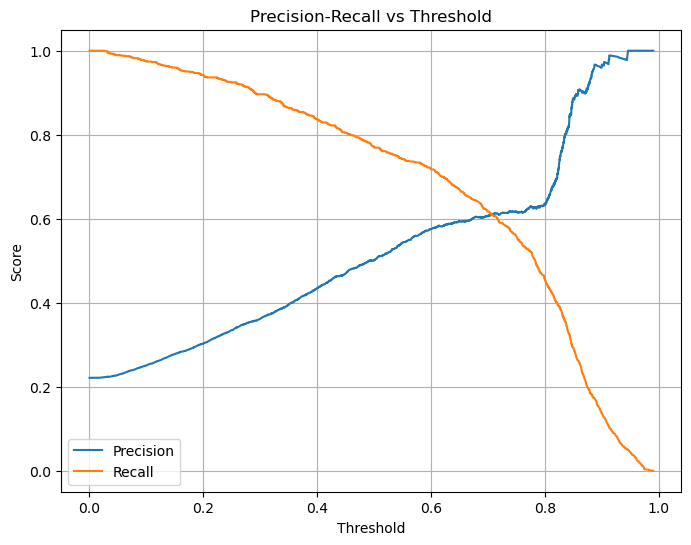

Threshold for 0.8 recall: 0.459


In [10]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


# Calculate precision-recall for different thresholds
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('Precision-Recall vs Threshold')
plt.show()

# Find threshold for specific recall (e.g., catch 80% of churners)
target_recall = 0.8
idx = np.argmin(np.abs(recall - target_recall))
optimal_threshold = thresholds[idx]
print(f"Threshold for {target_recall} recall: {optimal_threshold:.3f}")

In [ ]:
test_data = import_and_transform("Data/test.parquet")
test_data = aggregate(test_data)
test_data.set_index('userId', inplace=True)
test_data.drop(columns=features_to_drop, inplace=True)
test_data.drop(columns=['churned'], inplace=True)

test_data_scaled = pd.DataFrame(
    scaler.transform(test_data),
    index=test_data.index,
    columns=test_data.columns
)

# Use your optimal threshold!
evaluate_model_log_reg(log_reg, test_data_scaled, threshold=0.459, file_out='submission_optimized.csv')

# Compare with default threshold
evaluate_model_log_reg(log_reg, test_data_scaled, threshold=0.5, file_out='submission_default.csv')

Importing parquet file
Processed 2904 users
Churn rate: 0.00%
Submission saved to submission_optimized.csv
Predicted churn rate: 21.14%
Submission saved to submission_default.csv
Predicted churn rate: 17.11%


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [43]:
test_data = import_and_transform("Data/test.parquet")
test_data = aggregate(test_data)
test_data.set_index('userId', inplace=True)
test_data.drop(columns = features_to_drop, inplace = True)

Importing parquet file
Processed 2904 users
Churn rate: 0.00%


In [24]:
test_data.drop(columns = ['churned'], inplace = True)

In [25]:
test_data_scaled = pd.DataFrame(
    scaler.transform(test_data),
    index=test_data.index,
    columns=test_data.columns
)

In [26]:
evaluate_model(log_reg, test_data)

Submission saved to submission.csv


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# First, apply SMOTE to balance your training data
print('Before SMOTE - count of label 0: {}'.format(sum(y_train==0)))
print('Before SMOTE - count of label 1: {}'.format(sum(y_train==1)))

smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('After SMOTE - count of label 0: {}'.format(sum(y_train_resampled==0)))
print('After SMOTE - count of label 1: {}'.format(sum(y_train_resampled==1)))

# Now do grid search on the resampled data
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),  # Remove class_weight='balanced' since SMOTE already balanced the data
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Before SMOTE - count of label 0: 11891
Before SMOTE - count of label 1: 3421
After SMOTE - count of label 0: 11891
After SMOTE - count of label 1: 11891
Best params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.8678


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [31]:
evaluate_model(grid_search.best_estimator_, test_data)

Submission saved to submission.csv
